In [1]:
%run qsu.ipynb
import numpy as np
import sympy
import networkx as nx
from qecsim import paulitools as pt 
from qecsim.models.generic import DepolarizingErrorModel
from qecsim.models.toric import ToricCode
from tqdm import tqdm
import nbimporter
import galois
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from typing import List, Tuple
import hypergraph_prod_code as hpc
import time


In [2]:
def belief_prop(H: np.array, s: np.array, p: float, max_iter: int) -> Tuple:
    """ 
    Belief Propagation Algorithm for Decoding LDPC Codes

    Parameters:
    -----------
    H - parity-check matrix corresponding to either X or Z checks
    s - Error syndrome
    p - Channel error rate for chosen noise channel
    max_iter - Maximum number of iterations to run BP algorithm for
    """
    data_to_parity = np.zeros((len(H[0]),len(H)), dtype=float)
    parity_to_data = np.zeros((len(H), len(H[0])), dtype=float)
    H_tanner_graph = hpc.parity_check_mat_to_tanner(H)
    
    # Channel Log Likelihood Ratio
    p_l = np.log((1 - p)/p)
    
    P_1 = np.zeros((len(H[0]),), dtype=float)
    e_BP = np.zeros((len(H[0]),), dtype=float)

    # (1) Initialization
    for edge in H_tanner_graph.edges:
        data_node_num = int(edge[0][1:])
        parity_node_num = int(edge[1][1:])
        data_to_parity[data_node_num][parity_node_num] = p_l 

    for iter in range(1, max_iter + 1):
        # Scaling Factor
        a = 1 - 2**(-1 * iter)

        # (2) Parity to Data Messages
        for edge in H_tanner_graph.edges:
            parity_node_num = int(edge[1][1:])
            data_node_num = int(edge[0][1:])

            # Get list of neighbors of current parity_node set minus the current data node
            V = list(nx.neighbors(H_tanner_graph, edge[1]))
            V.remove(edge[0])

            # Get messages from elements of V to current parity node
            data_to_par_msgs = [data_to_parity[int(v[1:])][parity_node_num] for v in V]
            w = np.min([np.abs(msg) for msg in data_to_par_msgs])
            parity_to_data[parity_node_num][data_node_num] = ((-1) ** int(s[parity_node_num])) * a * np.prod(np.sign(data_to_par_msgs)) * w 

        # (3) Data to Parity Messages
        for edge in H_tanner_graph.edges:
            data_node_num = int(edge[0][1:])
            parity_node_num = int(edge[1][1:])

            # Get list of neighbors of current data node set minus the current parity node
            U = list(nx.neighbors(H_tanner_graph, edge[0]))
            U.remove(edge[1])

            # Get messages from elements of U to current data node
            par_to_data_msgs = [parity_to_data[int(u[1:])][data_node_num] for u in U]
            data_to_parity[data_node_num][parity_node_num] = p_l + np.sum(par_to_data_msgs)

        # Hard Decision
        for edge in H_tanner_graph.edges:
            data_node_num = int(edge[0][1:])
            parity_node_num = int(edge[1][1:])

            # Get list of neighbors of current data node
            U = list(nx.neighbors(H_tanner_graph, edge[0]))

            par_to_data_msgs = [parity_to_data[int(u[1:])][data_node_num] for u in U]
            P_1[data_node_num] = p_l + np.sum(par_to_data_msgs)
            e_BP[data_node_num] = -1 * np.sign(P_1[data_node_num])
        
        # (4) Termination Check
        e_BP = e_BP * (e_BP > 0)
        #print(e_BP)
        if (np.array_equal(np.dot(H, e_BP), s)):
            return True, e_BP, P_1 

    return False, e_BP, P_1

### Checks for Errors:
* Method of casting via GF
* Permutation of columns of $H$

In [3]:
def OSD_0(H: np.array, P_1: np.array, s: np.array) -> np.array:
    """ 
    The Ordered Statistics Decoding (OSD) Zero algorithm is a post-processing 
    algorithm utilized when BP fails to converge 

    Parameters:
    -----------
    H - parity check matrix
    P_1 - BP soft decision vector
    s - Error syndrome 

    Returns:
    --------
    Error string
    """
    GF = galois.GF(2)

    # Get rank of parity check matrix 
    H_rank = np.linalg.matrix_rank(GF(H))
    
    # Sort soft decision vector 
    P_1_sorted_pos = np.argsort(P_1, kind='stable')
    P_1_sorted = [P_1[i] for i in P_1_sorted_pos]

    # Remove remove row from 'H' and related position from 's'
    del_pos = np.random.choice(len(H))
    H_d = np.delete(H, del_pos, axis=0)
    s_d = GF(np.delete(s, del_pos, axis=0))

    # Rearrange columns of H to match the reordered soft-decision vector
    H_d[:] = H_d[:, P_1_sorted_pos]

    # Select first RANK(H) linearly independent columns of above rearrangement
    H_rref, inds = sympy.Matrix(H_d).rref(iszerofunc=lambda x : x % 2 == 0);
    H_S = GF(np.vstack(([H_d[:, inds[i]] for i in range(0, H_rank)])).T)
    #print(np.linalg.matrix_rank(H_S))
    #H_S_inv = GF(np.mod((np.linalg.inv(H_S)).astype('int32'),2))
    H_S_inv = np.linalg.inv(H_S)
    
    # Calculate the OSD-0 solution on the basis-bits
    e_S = H_S_inv @ GF(s_d)
    e_ST = np.hstack((e_S, GF(np.zeros((len(H[0]) - H_rank,), dtype='int32'))))
    
    
    # Map the OSD-0 solution to the original bit-ordering
    e_OSD = GF(np.zeros((len(H[0]),), dtype='int32'))
    for i in range(len(P_1_sorted_pos)):
        e_OSD[P_1_sorted_pos[i]] = e_ST[i]
    
    return e_OSD


In [4]:
def mod(x,modulus):
    numer, denom = x.as_numer_denom()
    return numer*sympy.mod_inverse(denom,modulus) % modulus    

# Turn to Ordered Statistics Decoding if BP fails to converge
def OSD_0_V1(H: np.array, P_1: np.array, s: np.array) -> np.array:
    """ 
    The Ordered Statistics Decoding (OSD) Zero algorithm is a post-processing 
    algorithm utilized when BP fails to converge 

    Parameters:
    -----------
    H - parity check matrix
    P_1 - BP soft decision vector
    s - Error syndrome 

    Returns:
    --------
    Error string
    """
    GF = galois.GF(2)
    # Get the rank of the parity check matrix
    H_rank = np.linalg.matrix_rank(GF(H))
    print(H_rank)

    # Maintain a mapping between bit positions and elements of the BP soft-decision vector
    P_1_sorted_pos = np.argsort(P_1, kind='stable')[::-1]
    P_1_sorted = [P_1[i] for i in P_1_sorted_pos]
    print(P_1_sorted_pos)
    print(P_1_sorted)

    # Rearrange columns of H to match the reordered soft-decision vector
    H[:] = H[:, P_1_sorted_pos]

    # Randomly remove a row from 'H' and related position from syndrome
    del_pos = np.random.choice(len(H))
    print(del_pos)
    print(H,s)
    H_del = np.delete(H, del_pos, axis=0)
    s_del = np.delete(s, del_pos)

    # Select first RANK(H) linearly independent columns of above rearrangement
    H_rref, inds = sympy.Matrix(H_del).rref()

    H_rref = H_rref.applyfunc(lambda x : mod(x,2))
    H_rref, inds = sympy.Matrix(H_rref).rref()
    H_S = np.vstack(([H_del[:, inds[i]] for i in range(0, H_rank)]))
    print(H_S)
    H_S_inv = np.mod(np.linalg.inv(H_S), 2)
    print(H_S_inv)
    

    # Calculate the OSD-0 solution on the basis-bits
    e_S = np.linalg.inv(H_S) @ s_del
    e_ST = np.hstack((e_S, np.zeros((len(H[0]) - H_rank,))))

    # Map the OSD-0 solution to the original bit-ordering
    e_OSD = np.zeros((len(H[0]),))
    for i in range(len(P_1_sorted_pos)):
        e_OSD[P_1_sorted_pos[i]] = e_ST[i]

    return e_OSD

In [5]:
def get_H_J(H:np.array, J: List, s_p: np.array):
    if (J == []):
        H_J = []
        H_J_s = np.array(s_p.T)
    else:
        H_J = np.vstack([H[:, i] for i in J])
        H_J_s = np.vstack((H_J,s_p)).T
    return H_J, H_J_s

def replace_pos(e_p: np.array, x: np.array, J: List):
    count = 0
    for i in range(len(e_p)):
        if(i in J):
            e_p[i] = x[count]
            count += 1

    return e_p


# Turn to Ordered Statistics Decoding if BP fails to converge
def OSD_0_V2(H: np.array, s: np.array, P_1: np.array, e_p: np.array, num_qubits: int) -> np.array:
    """ 
    The Ordered Statistics Decoding (OSD) Zero algorithm is a post-processing 
    algorithm utilized when BP fails to converge 

    Parameters:
    -----------
    H - Parity check matrix
    s - Error syndrome 
    P_1 - Soft decision vector
    e_p - Hard decision vector
    num_qubits - Number of qubits

    Returns:
    --------
    Error string e such that He = s
    """

    """
    # Maintain a mapping between bit positions and elements of the BP soft-decision vector
    P_1_sorted_pos = np.argsort(P_1, kind='stable')[::-1]
    P_1_sorted = [P_1[i] for i in P_1_sorted_pos]

    # Rearrange columns of H to match the reordered soft-decision vector
    H[:] = H[:, P_1_sorted_pos]
    """

    # Want to construct information set J
    J = []
    s_p = np.mod(s + (H @ e_p),2)
    for i in range(num_qubits):
        H_J, H_J_s = get_H_J(H, J, s_p)
        if (np.linalg.matrix_rank(H_J_s) == np.linalg.matrix_rank(H_J)):
            break 
        J_p = J + [i]
        H_J_p, _ = get_H_J(H, J_p, s_p)
        if (np.linalg.matrix_rank(H_J_p) > np.linalg.matrix_rank(H_J)):
            J = J_p
            s_p += e_p[i] * H[:,i]
    rref, _ = sympy.Matrix.rref(sympy.Matrix(H_J_s))
    x = rref[:,-1]
    e = replace_pos(e_p, x, s_p)
    return e

In [6]:
def OSD_0_V3(H: np.array, s: np.array, P_1: np.array, e_p: np.array, num_qubits: int) -> np.array:
    """ 
    The Ordered Statistics Decoding (OSD) Zero algorithm is a post-processing 
    algorithm utilized when BP fails to converge 

    Parameters:
    -----------
    H - Parity check matrix
    s - Error syndrome 
    P_1 - Soft decision vector
    e_p - Hard decision vector
    num_qubits - Number of qubits

    Returns:
    --------
    Error string e such that He = s
    """
    # Maintain a mapping between bit positions and elements of the BP soft-decision vector
    P_1_sorted_pos = np.argsort(P_1, kind='stable')[::-1]
    P_1_sorted = [P_1[i] for i in P_1_sorted_pos]

    # Rearrange columns of H to match the reordered soft-decision vector
    H[:] = H[:, P_1_sorted_pos]

    # Solve for He=s
    s = np.reshape(s, (len(s),1))
    aug_mat = sympy.Matrix(np.concatenate((H,s), axis=1), domain=sympy.ZZ(2))
    aug_mat, inds = sympy.Matrix.rref(aug_mat)
    print(np.array(aug_mat))
    
    

In [7]:
# Loop to see probability distribution evolution across many runs of BP decoder
def prob_likelihood_evol(dim: int):
    # Array of likelihoods (soft-decision vectors) for each run
    BP_like_Z = []
    BP_like_X = []

    # Define code
    my_code = ToricCode(dim, dim);
    my_error_model = DepolarizingErrorModel()
    
    # Define error probability and randomly select seed for errors
    error_probability = 0.1 
    rn = np.random.randint(1,100000)
    rng = np.random.default_rng(rn)

    # Get random error
    error = my_error_model.generate(my_code, error_probability, rng)

    # Get syndrome of error
    syndrome = pt.bsp(error, my_code.stabilizers.T)

    # Get X and Z parity check matrices and related error vectors 
    Z_stabs = (my_code.stabilizers[:dim ** 2])[:, 2 * dim ** 2:]
    X_stabs = (my_code.stabilizers[dim ** 2:])[:, :2 * dim ** 2]
    Z_error = error[2 * dim**2:]
    X_error = error[:2 * dim**2]
    Z_syndrome = np.mod(X_stabs @ Z_error,2)
    X_syndrome = np.mod(Z_stabs @ X_error, 2)

    for num_iter in range(1, 2 * dim ** 2 + 1):
        converged_Z, e_BP_Z, P_1_Z = belief_prop(X_stabs, Z_syndrome, error_probability, num_iter)
        converged_X, e_BP_X, P_1_X = belief_prop(Z_stabs, X_syndrome, error_probability, num_iter)
        
        BP_like_Z.append(P_1_Z)
        BP_like_Z.append(P_1_X)

    BP_like_Z = np.array(BP_like_Z)
    BP_like_X = np.array(BP_like_X)
    return (BP_like_Z, BP_like_X)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


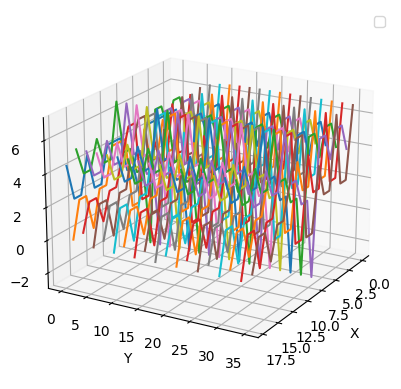

In [8]:
dim = 3
SD_Z, SD_X = prob_likelihood_evol(dim)

ax_Z = plt.figure().add_subplot(projection='3d')
#ax_X = plt.figure().add_subplot(projection='3d')

x = np.linspace(0, 17, 18)
y = SD_Z[15]

# By using zdir='y', the y value of these points is fixed to the zs value 0
# and the (x, y) points are plotted on the x and z axes.
for i in range(len(SD_Z)):
    ax_Z.plot(x, SD_Z[i], zs=i, zdir='y', c=None)
#    ax_X.plot(x, SD_X[i], zs=i, zdir='y', c=None)

# Make legend, set axes limits and labels
ax_Z.legend()
ax_Z.set_xlabel('X')
ax_Z.set_ylabel('Y')
ax_Z.set_zlabel('Z')

#ax_X.legend()
#ax_X.set_xlabel('X')
#ax_X.set_ylabel('Y')
#ax_X.set_zlabel('Z')

# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
ax_Z.view_init(elev=20., azim=30)

plt.show()

In [9]:
# initialize models
dim = 6
my_code = ToricCode(dim,dim)
my_error_model = DepolarizingErrorModel()
GF = galois.GF(2)

In [10]:
# Set physical error probability to 10%
error_probability = 0.12
# Seed random number generator for repeatability
#rng = np.random.default_rng(15355)
rng = np.random.default_rng()

# Error: random error based on error probability
error = my_error_model.generate(my_code, error_probability, rng)
while (sum(error) == 0):
    error = my_error_model.generate(my_code, error_probability, rng)
print(error)
print(('error:\n{}'.format(my_code.new_pauli(error))))

[0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
error:
┼─·─┼─Y─┼─·─┼─·─┼─·─┼─·
Z   ·   Z   ·   ·   ·  
┼─Y─┼─·─┼─·─┼─·─┼─X─┼─·
·   ·   ·   ·   ·   ·  
┼─X─┼─·─┼─·─┼─·─┼─·─┼─·
·   ·   ·   ·   ·   ·  
┼─·─┼─·─┼─X─┼─·─┼─Y─┼─·
·   ·   ·   ·   ·   ·  
┼─·─┼─·─┼─·─┼─·─┼─·─┼─·
·   ·   ·   ·   ·   ·  
┼─·─┼─·─┼─·─┼─Z─┼─·─┼─·
·   ·   ·   ·   ·   ·  


In [11]:
# Syndrome: Stabilizers that do not commute with the error
syndrome = pt.bsp(error, my_code.stabilizers.T)
print(syndrome)
print(('syndrome:\n{}'.format(my_code.ascii_art(syndrome))))

[1 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0]
syndrome:
X───X───┼───┼───┼───┼──
│ Z │ Z │   │   │ Z │  
┼───X───X───┼───┼───┼──
│   │   │   │   │ Z │  
┼───┼───┼───┼───┼───┼──
│ Z │   │ Z │   │ Z │  
┼───┼───┼───┼───X───X──
│   │   │ Z │   │ Z │  
┼───┼───┼───┼───┼───┼──
│   │   │   │   │   │  
┼───┼───┼───X───X───┼──
│   │ Z │   │   │   │  


In [12]:
Z_stabs = (my_code.stabilizers[:dim ** 2])[:, 2 * dim ** 2:]
X_stabs = (my_code.stabilizers[dim ** 2:])[:, :2 * dim ** 2]
#print(str(Z_stabs) + "\n" + str(X_stabs))
#print(np.mod(X_stabs @ Z_stabs.T,2))
Z_error = error[2 * dim**2:]
X_error = error[:2 * dim**2]
print("Z_error: " + str(Z_error))
print("X_error: " + str(X_error))

Z_error: [0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
X_error: [0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [13]:
Z_syndrome = np.mod(X_stabs @ Z_error,2)
print("Z_syndrome: " + str(Z_syndrome))
X_syndrome = np.mod(Z_stabs @ X_error, 2)
print("X_syndrome: " + str(X_syndrome))

Z_syndrome: [0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0]
X_syndrome: [1 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0]


In [20]:
converged_Z, e_BP_Z, P_1_Z = belief_prop(X_stabs, Z_syndrome, 0.1, np.log(np.log(2 * dim ** 2)).astype(int))
converged_X, e_BP_X, P_1_X = belief_prop(Z_stabs, X_syndrome, 0.1, np.log(np.log(2 * dim ** 2)).astype(int))

In [21]:
print(converged_Z, e_BP_Z, P_1_Z)
print('\n')
print(converged_X, e_BP_X, P_1_X)

False [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.] [0.         2.19722458 4.39444915 4.39444915 4.39444915 2.19722458
 2.19722458 0.         2.19722458 4.39444915 4.39444915 4.39444915
 4.39444915 4.39444915 4.39444915 4.39444915 4.39444915 4.39444915
 4.39444915 4.39444915 4.39444915 2.19722458 0.         2.19722458
 4.39444915 4.39444915 4.39444915 4.39444915 4.39444915 4.39444915
 4.39444915 4.39444915 2.19722458 0.         2.19722458 4.39444915
 2.19722458 0.         2.19722458 4.39444915 4.39444915 4.39444915
 4.39444915 2.19722458 2.19722458 4.39444915 4.39444915 4.39444915
 4.39444915 4.39444915 4.39444915 4.39444915 2.19722458 2.19722458
 4.39444915 4.39444915 4.39444915 4.39444915 2.19722458 2.19722458
 4.39444915 4.39444915 4.394449

In [22]:
if (converged_X == True and converged_Z == True):
    e_OSD_Z = e_BP_Z
    e_OSD_X = e_BP_X
if (converged_Z == False):
    print("BP ON Z FAILED")
    #e_OSD_Z = np.mod(OSD_0_V2(X_stabs, Z_syndrome, P_1_Z, e_BP_Z, 2 * dim ** 2), 2)
    #e_OSD_Z = np.mod(OSD_0_V3(X_stabs, Z_syndrome, P_1_Z, e_BP_Z, 2 * dim ** 2), 2)
    e_OSD_Z = np.array(OSD_0(X_stabs, P_1_Z, Z_syndrome))
    if (converged_X == True):
        e_OSD_X = e_BP_X
    print(e_OSD_Z)
if (converged_X == False):
    print("BP ON X FAILED")
    #e_OSD_X = np.mod(OSD_0_V2(Z_stabs, X_syndrome, P_1_X, e_BP_X, 2 * dim ** 2), 2)
    #e_OSD_X = np.mod(OSD_0_V3(Z_stabs, X_syndrome, P_1_X, e_BP_X, 2 * dim ** 2), 2)
    e_OSD_X = np.array(OSD_0(Z_stabs, P_1_X, X_syndrome))
    if (converged_Z == True):
        e_OSD_Z = e_BP_Z
    print(e_OSD_X)

BP ON Z FAILED
[1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
BP ON X FAILED
[0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [23]:
# Check consistency with syndromes measured.
print(np.mod(X_stabs @ e_OSD_Z, 2))
print(np.mod(Z_stabs @ e_OSD_X, 2))

[0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0]
[1 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0]


In [24]:
print("Error: " + str(error))
recovery = np.array((np.hstack((e_OSD_X, e_OSD_Z))), dtype='int32')
print("Recovery operation: " + str(recovery))

# check recovery ^ error commutes with stabilizers
print("Commutation with stabilizers: " + str(pt.bsp(recovery ^ error, my_code.stabilizers.T)))

# success iff recovery ^ error commutes with logicals
print("Commutation with logicals: " + str(pt.bsp(recovery ^ error, my_code.logicals.T)))
print("Commutation recovery and stabs: " + str(pt.bsp(recovery, my_code.stabilizers.T)))
print("Commutation original error and stabs: " + str(pt.bsp(error, my_code.stabilizers.T)))
print(np.all(pt.bsp(recovery, my_code.stabilizers.T) == pt.bsp(error, my_code.stabilizers.T)))

Error: [0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Recovery operation: [0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Commutation with stabilizers: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Commutation with logicals: [0 0 0 0]
Commutation recovery and stabs: [1 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0

In [25]:
"""get the syndrome of the pauli operator """

def twisted_product(stab_binary, pauli_binary):
    """
    take twisted product of stabilizer with pauli to calculate commutator 
    """
    
    if len(stab_binary.shape) == 1:
        # if we have only 1 stabilizer
        L = int(len(stab_binary)/2)
        return (stab_binary[:L]@pauli_binary[L:] + stab_binary[L:]@pauli_binary[:L]) % 2
    else:
        # if we have a parity check 
        L = int(stab_binary.shape[1]/2)
        assert stab_binary.shape[1] == len(pauli_binary)
        syndrome = []
        for i in range(stab_binary.shape[0]):
            syndrome.append((stab_binary[i, :L]@pauli_binary[L:] + stab_binary[i, L:]@pauli_binary[:L]) % 2)
        return np.array(syndrome)

In [28]:
dim = 6
my_code = ToricCode(dim,dim)
my_error_model = DepolarizingErrorModel()
GF = galois.GF(2)

num_rounds = 1000
codespace_projection = [0]*num_rounds
logical_errors = [0]*num_rounds
uncorrected_logical_error_rate = [0]*num_rounds
error_probability = 0.08
count = 0
error_string = ""
f = open('codespace_proj_err.txt', 'w')

for r in tqdm(range(num_rounds)):
    error_string = ""
    rng = np.random.default_rng()
    # Error: random error based on error probability
    error = my_error_model.generate(my_code, error_probability, rng)
    while (sum(error) == 0):
        error = my_error_model.generate(my_code, error_probability, rng)

    error_string += "ERROR: " + str(repr(error)) + '\n'
    error_string += ('error:\n{}'.format(my_code.new_pauli(error))) +'\n'

    syndrome = pt.bsp(error, my_code.stabilizers.T)
    error_string += "SYNDROME: " + str(syndrome) + '\n'
    error_string += ('syndrome:\n{}'.format(my_code.ascii_art(syndrome))) + '\n'
    Z_stabs = (my_code.stabilizers[:dim ** 2])[:, 2 * dim ** 2:]
    X_stabs = (my_code.stabilizers[dim ** 2:])[:, :2 * dim ** 2]
    Z_error = error[2 * dim**2:]
    X_error = error[:2 * dim**2]
    Z_syndrome = np.mod(X_stabs @ Z_error,2)
    X_syndrome = np.mod(Z_stabs @ X_error, 2)
    converged_Z, e_BP_Z, P_1_Z = belief_prop(X_stabs, Z_syndrome, 0.08, np.log(np.log(2 * dim ** 2)).astype(int))
    converged_X, e_BP_X, P_1_X = belief_prop(Z_stabs, X_syndrome, 0.08, np.log(np.log(2 * dim ** 2)).astype(int))
    error_string += "SOFT-DECISION VECTOR (Z ERROR): " + str(P_1_Z) + '\n' + "HARD-DECISION VECTOR (Z ERROR): " + str(e_BP_Z) + '\n'
    error_string += "CONVERGED FOR Z?: " + str(converged_Z) + '\n'
    error_string += "SOFT-DECISION VECTOR (X ERROR): " + str(P_1_X) + '\n' + "HARD-DECISION VECTOR (X ERROR): " + str(e_BP_X) + '\n'
    error_string += "CONVERGED FOR X?: " + str(converged_X) + '\n'
    if (converged_X == True and converged_Z == True):
        e_OSD_Z = e_BP_Z
        e_OSD_X = e_BP_X
    if (converged_Z == False):
        e_OSD_Z = np.array(OSD_0(X_stabs, P_1_Z, Z_syndrome))
        if (converged_X == True):
            e_OSD_X = e_BP_X
    if (converged_X == False):
        e_OSD_X = np.array(OSD_0(Z_stabs, P_1_X, X_syndrome))
        if (converged_Z == True):
            e_OSD_Z = e_BP_Z

    error_string += "RESULT OF OSD (Z ERROR): " + str(e_OSD_Z) + '\n'
    error_string += "RESULT OF OSD (X ERROR): " + str(e_OSD_X) + '\n'

    recovery = np.array((np.hstack((e_OSD_X, e_OSD_Z))), dtype='int32')

    error_string += "RECOVERY OPERATOR: " + str(recovery) + '\n' 
    error_string += "COMMUTATION OF RECOVERY WITH STABS: " + str(pt.bsp(recovery, my_code.stabilizers.T)) + '\n'
    error_string += "COMMUTATION OF ORIGINAL ERROR WITH STABS: " + str(pt.bsp(error, my_code.stabilizers.T)) + '\n' 
    error_string += "CONSISTENT COMMUTATION RELATIONS: " + str(np.all(pt.bsp(recovery, my_code.stabilizers.T) == pt.bsp(error, my_code.stabilizers.T))) + '\n'
    error_string += '\n'

    if sum(pt.bsp(recovery ^ error, my_code.stabilizers.T)) > 0:
        codespace_projection[r] = 1
        f.write(error_string)
    if sum(pt.bsp(recovery ^ error, my_code.logicals.T)) > 0:
        logical_errors[r] = 1
    if sum(pt.bsp(error, my_code.logicals.T)) > 0:
        uncorrected_logical_error_rate[r] = 1
    
f.close()

100%|██████████| 1000/1000 [01:20<00:00, 12.35it/s]


In [29]:
print('number of codespace projection failures', sum(codespace_projection))
print('logical error rate', sum(logical_errors)/len(logical_errors))
print('uncorrected error rate', sum(uncorrected_logical_error_rate)/len(uncorrected_logical_error_rate))
print('physical error rate', error_probability)

number of codespace projection failures 360
logical error rate 0.207
uncorrected error rate 0.675
physical error rate 0.08


### Running OSD Decoder After Varying Iterations of BP

In [30]:
def testing_BP_plus_OSD(H: np.array, s: np.array, p: float, max_iter: int) -> Tuple:
    """ 
    Belief Propagation Plus OSD Testing Function

    Parameters:
    -----------
    H - parity-check matrix corresponding to either X or Z checks
    s - Error syndrome
    p - Channel error rate for chosen noise channel
    max_iter - Maximum number of iterations to run BP algorithm for
    """
    data_to_parity = np.zeros((len(H[0]),len(H)), dtype=float)
    parity_to_data = np.zeros((len(H), len(H[0])), dtype=float)
    H_tanner_graph = hpc.parity_check_mat_to_tanner(H)
    
    # Channel Log Likelihood Ratio
    p_l = np.log((1 - p)/p)
    
    P_1 = np.zeros((len(H[0]),), dtype=float)
    e_BP = np.zeros((len(H[0]),), dtype=float)

    # (1) Initialization
    for edge in H_tanner_graph.edges:
        data_node_num = int(edge[0][1:])
        parity_node_num = int(edge[1][1:])
        data_to_parity[data_node_num][parity_node_num] = p_l 

    for iter in range(1, max_iter + 1):
        # Scaling Factor
        a = 1 - 2**(-1 * iter)

        # (2) Parity to Data Messages
        for edge in H_tanner_graph.edges:
            parity_node_num = int(edge[1][1:])
            data_node_num = int(edge[0][1:])

            # Get list of neighbors of current parity_node set minus the current data node
            V = list(nx.neighbors(H_tanner_graph, edge[1]))
            V.remove(edge[0])

            # Get messages from elements of V to current parity node
            data_to_par_msgs = [data_to_parity[int(v[1:])][parity_node_num] for v in V]
            w = np.min([np.abs(msg) for msg in data_to_par_msgs])
            parity_to_data[parity_node_num][data_node_num] = ((-1) ** int(s[parity_node_num])) * a * np.prod(np.sign(data_to_par_msgs)) * w 

        # (3) Data to Parity Messages
        for edge in H_tanner_graph.edges:
            data_node_num = int(edge[0][1:])
            parity_node_num = int(edge[1][1:])

            # Get list of neighbors of current data node set minus the current parity node
            U = list(nx.neighbors(H_tanner_graph, edge[0]))
            U.remove(edge[1])

            # Get messages from elements of U to current data node
            par_to_data_msgs = [parity_to_data[int(u[1:])][data_node_num] for u in U]
            data_to_parity[data_node_num][parity_node_num] = p_l + np.sum(par_to_data_msgs)

        # Hard Decision
        for edge in H_tanner_graph.edges:
            data_node_num = int(edge[0][1:])
            parity_node_num = int(edge[1][1:])

            # Get list of neighbors of current data node
            U = list(nx.neighbors(H_tanner_graph, edge[0]))

            par_to_data_msgs = [parity_to_data[int(u[1:])][data_node_num] for u in U]
            P_1[data_node_num] = p_l + np.sum(par_to_data_msgs)
            e_BP[data_node_num] = -1 * np.sign(P_1[data_node_num])

        # Run OSD
        e_OSD = OSD_0(H, P_1, s)
        #print(e_OSD)

        # Termination Check for OSD
        if (np.array_equal(np.dot(GF(H), e_OSD), s)):
            #print("Terminated due to OSD")
            return True, e_OSD, P_1
        
        # (4) Termination Check
        e_BP = e_BP * (e_BP > 0)
        #print(e_BP)
        if (np.array_equal(np.dot(H, e_BP), s)):
            #print("Terminated due to BP")
            return True, e_BP, P_1 

    return False, e_BP, P_1

In [31]:
dim = 6
my_code = ToricCode(dim,dim)
my_error_model = DepolarizingErrorModel()
rng = np.random.default_rng()

error = my_error_model.generate(my_code, error_probability, rng)
while (sum(error) == 0):
    error = my_error_model.generate(my_code, error_probability, rng)

error = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
print('error:\n{}'.format(my_code.new_pauli(error)))
    
syndrome = pt.bsp(error, my_code.stabilizers.T)
print('syndrome:\n{}'.format(my_code.ascii_art(syndrome)))

Z_stabs = (my_code.stabilizers[:dim ** 2])[:, 2 * dim ** 2:]
X_stabs = (my_code.stabilizers[dim ** 2:])[:, :2 * dim ** 2]
Z_error = error[2 * dim**2:]
X_error = error[:2 * dim**2]
Z_syndrome = np.mod(X_stabs @ Z_error,2)
X_syndrome = np.mod(Z_stabs @ X_error, 2)
print("FOR Z ERRORS")
#converged_Z, e_BP_Z, P_1_Z = testing_BP_plus_OSD(X_stabs, Z_syndrome, 0.08, 2 * dim ** 2)
converged_Z, e_BP_Z, P_1_Z = testing_BP_plus_OSD(X_stabs, Z_syndrome, 0.08, np.log(np.log(2 * dim ** 2)).astype(int))

print(converged_Z)
print("FOR X ERRORS")
#converged_X, e_BP_X, P_1_X = testing_BP_plus_OSD(Z_stabs, X_syndrome, 0.08, 2 * dim ** 2)
converged_X, e_BP_X, P_1_X = testing_BP_plus_OSD(Z_stabs, X_syndrome, 0.08, np.log(np.log(2 * dim ** 2)).astype(int))

print(converged_X)
print("GOING TO SLEEP")
time.sleep(5)
print("WOKEN UP")
if (converged_X == True and converged_Z == True):
    e_OSD_Z = e_BP_Z
    e_OSD_X = e_BP_X
if (converged_Z == False):
    e_OSD_Z = np.array(OSD_0(X_stabs, P_1_Z, Z_syndrome))
    if (converged_X == True):
        e_OSD_X = e_BP_X
if (converged_X == False):
    e_OSD_X = np.array(OSD_0(Z_stabs, P_1_X, X_syndrome))
    if (converged_Z == True):
        e_OSD_Z = e_BP_Z
print("Error: " + str(error))
recovery = np.array((np.hstack((e_OSD_X, e_OSD_Z))), dtype='int32')
print("Recovery operation: " + str(recovery))

# check recovery ^ error commutes with stabilizers
print("Commutation with stabilizers: " + str(pt.bsp(recovery ^ error, my_code.stabilizers.T)))

# success iff recovery ^ error commutes with logicals
print("Commutation with logicals: " + str(pt.bsp(recovery ^ error, my_code.logicals.T)))
print("Commutation recovery and stabs: " + str(pt.bsp(recovery, my_code.stabilizers.T)))
print("Commutation original error and stabs: " + str(pt.bsp(error, my_code.stabilizers.T)))
print(np.all(pt.bsp(recovery, my_code.stabilizers.T) == pt.bsp(error, my_code.stabilizers.T)))

error:
┼─·─┼─·─┼─·─┼─·─┼─·─┼─·
·   ·   ·   ·   ·   ·  
┼─·─┼─·─┼─·─┼─·─┼─·─┼─·
·   ·   ·   ·   ·   ·  
┼─·─┼─·─┼─·─┼─·─┼─·─┼─Z
Y   ·   ·   ·   ·   ·  
┼─·─┼─·─┼─·─┼─·─┼─·─┼─·
·   ·   ·   ·   ·   ·  
┼─·─┼─·─┼─·─┼─·─┼─·─┼─·
·   ·   ·   ·   ·   ·  
┼─·─┼─·─┼─·─┼─·─┼─Y─┼─·
·   ·   ·   ·   Z   ·  
syndrome:
┼───┼───┼───┼───X───┼──
│   │   │   │   │   │  
┼───┼───┼───┼───┼───┼──
│   │   │   │   │   │  
┼───┼───┼───┼───┼───X──
│ Z │   │   │   │   │ Z
X───┼───┼───┼───┼───┼──
│   │   │   │   │   │  
┼───┼───┼───┼───┼───┼──
│   │   │   │   │ Z │  
┼───┼───┼───┼───┼───X──
│   │   │   │   │ Z │  
FOR Z ERRORS
False
FOR X ERRORS
True
GOING TO SLEEP
WOKEN UP
Error: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
Recovery operation: [0 0 0 0 0 0 0 0 0 0 0 0 0

In [34]:
# Testing with OSD injected into BP Decoder

dim = 6
my_code = ToricCode(dim,dim)
my_error_model = DepolarizingErrorModel()
GF = galois.GF(2)

num_rounds = 100
codespace_projection = [0]*num_rounds
logical_errors = [0]*num_rounds
uncorrected_logical_error_rate = [0]*num_rounds
error_probability = 0.08
count = 0
error_string = ""
f = open('codespace_proj_err.txt', 'w')

for r in tqdm(range(num_rounds)):
    start_time = time.time()
    error_string = ""
    rng = np.random.default_rng()
    # Error: random error based on error probability
    error = my_error_model.generate(my_code, error_probability, rng)
    while (sum(error) == 0):
        error = my_error_model.generate(my_code, error_probability, rng)

    error_string += "ERROR: " + str(repr(error)) + '\n'
    error_string += ('error:\n{}'.format(my_code.new_pauli(error))) +'\n'

    syndrome = pt.bsp(error, my_code.stabilizers.T)
    error_string += "SYNDROME: " + str(syndrome) + '\n'
    error_string += ('syndrome:\n{}'.format(my_code.ascii_art(syndrome))) + '\n'
    Z_stabs = (my_code.stabilizers[:dim ** 2])[:, 2 * dim ** 2:]
    X_stabs = (my_code.stabilizers[dim ** 2:])[:, :2 * dim ** 2]
    Z_error = error[2 * dim**2:]
    X_error = error[:2 * dim**2]
    Z_syndrome = np.mod(X_stabs @ Z_error,2)
    X_syndrome = np.mod(Z_stabs @ X_error, 2)
    converged_Z, e_BP_Z, P_1_Z = testing_BP_plus_OSD(X_stabs, Z_syndrome, 0.08, 2 * dim ** 2)
    # converged_Z, e_BP_Z, P_1_Z = testing_BP_plus_OSD(X_stabs, Z_syndrome, 0.08, np.log(np.log(2 * dim ** 2)).astype(int)) 
    converged_X, e_BP_X, P_1_X = testing_BP_plus_OSD(Z_stabs, X_syndrome, 0.08, 2 * dim ** 2)
    # converged_X, e_BP_X, P_1_X = testing_BP_plus_OSD(Z_stabs, X_syndrome, 0.08, np.log(np.log(2 * dim ** 2)).astype(int))
    error_string += "SOFT-DECISION VECTOR (Z ERROR): " + str(P_1_Z) + '\n' + "HARD-DECISION VECTOR (Z ERROR): " + str(e_BP_Z) + '\n'
    error_string += "CONVERGED FOR Z?: " + str(converged_Z) + '\n'
    error_string += "SOFT-DECISION VECTOR (X ERROR): " + str(P_1_X) + '\n' + "HARD-DECISION VECTOR (X ERROR): " + str(e_BP_X) + '\n'
    error_string += "CONVERGED FOR X?: " + str(converged_X) + '\n'
    if (converged_X == True and converged_Z == True):
        e_OSD_Z = e_BP_Z
        e_OSD_X = e_BP_X
    if (converged_Z == False):
        e_OSD_Z = np.array(OSD_0(X_stabs, P_1_Z, Z_syndrome))
        if (converged_X == True):
            e_OSD_X = e_BP_X
    if (converged_X == False):
        e_OSD_X = np.array(OSD_0(Z_stabs, P_1_X, X_syndrome))
        if (converged_Z == True):
            e_OSD_Z = e_BP_Z

    error_string += "RESULT OF OSD (Z ERROR): " + str(e_OSD_Z) + '\n'
    error_string += "RESULT OF OSD (X ERROR): " + str(e_OSD_X) + '\n'

    recovery = np.array((np.hstack((e_OSD_X, e_OSD_Z))), dtype='int32')

    error_string += "RECOVERY OPERATOR: " + str(recovery) + '\n' 
    error_string += "COMMUTATION OF RECOVERY WITH STABS: " + str(pt.bsp(recovery, my_code.stabilizers.T)) + '\n'
    error_string += "COMMUTATION OF ORIGINAL ERROR WITH STABS: " + str(pt.bsp(error, my_code.stabilizers.T)) + '\n' 
    error_string += "CONSISTENT COMMUTATION RELATIONS: " + str(np.all(pt.bsp(recovery, my_code.stabilizers.T) == pt.bsp(error, my_code.stabilizers.T))) + '\n'
    runtime = time.time() - start_time
    error_string += "ROUND RUNTIME: " + str(runtime)
    error_string += '\n'

    if sum(pt.bsp(recovery ^ error, my_code.stabilizers.T)) > 0:
        codespace_projection[r] = 1
        f.write(error_string)
    if sum(pt.bsp(recovery ^ error, my_code.logicals.T)) > 0:
        logical_errors[r] = 1
    if sum(pt.bsp(error, my_code.logicals.T)) > 0:
        uncorrected_logical_error_rate[r] = 1
    
f.close()

100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


In [35]:
print('number of codespace projection failures', sum(codespace_projection))
print('logical erro br rate', sum(logical_errors)/len(logical_errors))
print('uncorrected error rate', sum(uncorrected_logical_error_rate)/len(uncorrected_logical_error_rate))
print('physical error rate', error_probability)

number of codespace projection failures 5
logical erro br rate 0.08
uncorrected error rate 0.68
physical error rate 0.08
